In [1]:
from constants import *
from utils import *
from modules import *
import random
import time
from collections import Counter
from collections import defaultdict
%matplotlib inline

In [2]:
def calc_change_point_info(desc_share_d, key_event_months, window=1, random_baseline=False): # requires full 30 months data
    desc_type_set = set(desc_share_d['desc_type'])
    num_cp_descs = len(desc_type_set)
    month_info_list = sorted(set(desc_share_d['month_info']))
    shares_list = [[] for i in range(len(month_info_list))]
    for i, desc in enumerate(desc_type_set):
        for j, month in enumerate(month_info_list):
            d_list = [_share for _month, _share, _desc in zip(desc_share_d['month_info'], desc_share_d['desc_share'], desc_share_d['desc_type']) if _month == month and _desc == desc]
            mean_share_d = np.mean(d_list)
            shares_list[j].append(mean_share_d)
    key_change_rate = []
    nonkey_change_rate = []
    random.seed(2018)
    random_key_months = random.sample(list(set(month_info_list)), len(key_event_months))
    for i, (month, shares) in enumerate(zip(month_info_list, shares_list)):
        if i < window: # we can use 1 alternatively
            continue
        sum_shares = sum(shares)
        norm_shares = [share / sum_shares for share in shares]
        weighted_change_rate = 0
        for j in range(num_cp_descs):
            prev_mean = np.mean([shares_list[_i][j] for _i in range(i - window, i)])
            change_rate = abs((shares[j] - prev_mean) / prev_mean)
            weighted_change_rate += norm_shares[j] * change_rate
        if random_baseline:
            if month in random_key_months:
                key_change_rate.append(weighted_change_rate)
            else:
                nonkey_change_rate.append(weighted_change_rate)
            continue
        if month in key_event_months or month[2:] in key_event_months: # month format issue
            key_change_rate.append(weighted_change_rate)
        else:
            nonkey_change_rate.append(weighted_change_rate)
    return key_change_rate, nonkey_change_rate

In [3]:
vis_dict_we, key_event_dict = pickle.load(open('change_point_resource_we.pkl', 'rb'))
vis_dict_mohit, key_event_dict = pickle.load(open('change_point_resource_mohit.pkl', 'rb'))

In [7]:
we_agg_key_change_rate = []
we_agg_nonkey_change_rate = []
for rel in vis_dict_we.keys():
    kcr, nkcr = calc_change_point_info(vis_dict_we[rel][0], key_event_dict['Internation'][rel].keys(), window=6)
    we_agg_key_change_rate.extend(kcr)
    we_agg_nonkey_change_rate.extend(nkcr)

In [8]:
mohit_agg_key_change_rate = []
mohit_agg_nonkey_change_rate = []
for rel in vis_dict_mohit.keys():
    kcr, nkcr = calc_change_point_info(vis_dict_mohit[rel][0], key_event_dict['Internation'][rel].keys(), window=6)
    mohit_agg_key_change_rate.extend(kcr)
    mohit_agg_nonkey_change_rate.extend(nkcr)

In [9]:
random_agg_key_change_rate = []
random_agg_nonkey_change_rate = []
for rel in vis_dict_we.keys():
    kcr, nkcr = calc_change_point_info(vis_dict_we[rel][0], key_event_dict['Internation'][rel].keys(), window=6, random_baseline=True)
    random_agg_key_change_rate.extend(kcr)
    random_agg_nonkey_change_rate.extend(nkcr)

In [11]:
print(np.mean(we_agg_key_change_rate), np.mean(we_agg_nonkey_change_rate))
print(np.mean(mohit_agg_key_change_rate), np.mean(mohit_agg_nonkey_change_rate))

0.12435728232236948 0.07450681790828122
0.06805599204129911 0.045348531781668186


In [12]:
print(np.mean(random_agg_key_change_rate), np.mean(random_agg_nonkey_change_rate))

0.08193818602626632 0.08381950896023052


In [14]:
cp_info_dict = {'month': [], 'change_rate': [], 'model': []}
for elem in we_agg_key_change_rate:
    cp_info_dict['month'].append('Key event months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('LARN')
for elem in mohit_agg_key_change_rate:
    cp_info_dict['month'].append('Key event months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('RMN')
for elem in random_agg_key_change_rate:
    cp_info_dict['month'].append('Key event months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('Random')
for elem in we_agg_nonkey_change_rate:
    cp_info_dict['month'].append('Other months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('LARN')
for elem in mohit_agg_nonkey_change_rate:
    cp_info_dict['month'].append('Other months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('RMN')
for elem in random_agg_nonkey_change_rate:
    cp_info_dict['month'].append('Other months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('Random')

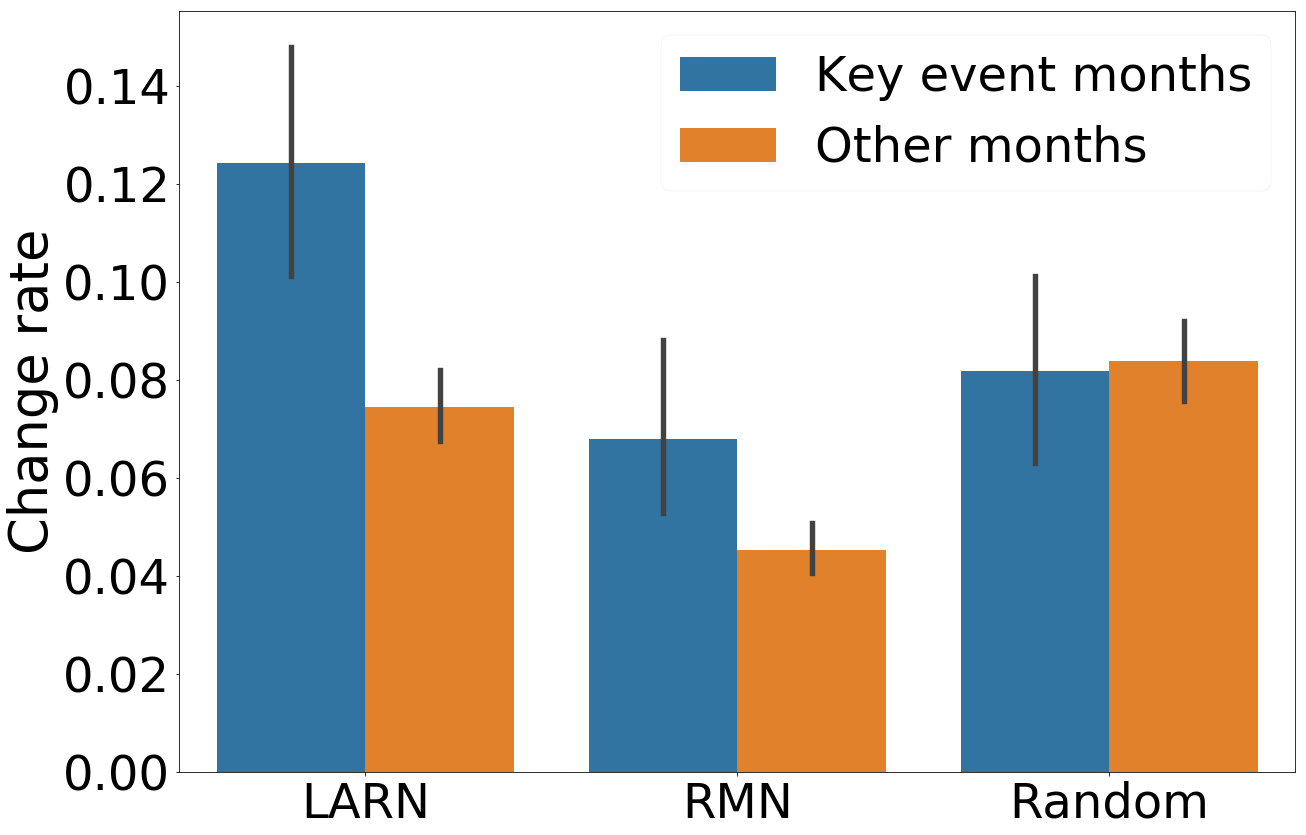

In [15]:
from matplotlib.ticker import FormatStrFormatter

sns.set_context("paper", font_scale=6, rc={"lines.linewidth": 3})
plt.figure(figsize=(20,14))
ax = sns.barplot(x='model', y='change_rate', hue='month', data=cp_info_dict)

ax.yaxis.set_label_text('Change rate')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_ticks(np.arange(0, 0.14, 0.02))
#ax.set(ylim=(0, None))
ax.figure.savefig('figures/cpa_1.pdf', dpi=200, bbox_inches='tight')

## Second set of annotation

In [16]:
key_event_dict = defaultdict(dict)

key_event_dict['Internation']['U.S. AND Russia'] = {'16-02': "U.S.-Russian deal on a ``cessation of hostilities''",
                                                    '16-09': "Russia and the U.S. announce joint peace plan for Syria",
                                                    '16-10': "Russian interference with election",
                                                    '17-01': "The U.S. Office of the Director of National Intelligence releases a declassified version of the Intelligence Community’s assessment that ``Putin ordered an influence campaign in 2016 aimed at the U.S. presidential election''",
                                                    '17-04': "US airstrike Syria",
                                                    '17-05': "Comey fired and Trump met Russian ambassadors",
                                                    '17-07': "Trump met Putin at G20 summit",
                                                    '18-04': "Missile strikes against Syria"}

key_event_dict['Internation']['U.S. AND China'] = {'16-02': "China Sends Missiles to Contested South China Sea Island",
                                                   '16-06': "Xi urges caution over THAAD deployment in South Korea",
                                                   '16-12': "Trump-Tsai call",
                                                   '17-02': "Trump affirms One China policy",
                                                   '17-04': "Xi visits US",
                                                   '17-11': "Trump visited Beijing",
                                                   '18-03': "tariff targets China",
                                                   '18-04': "China retaliates"}

key_event_dict['Internation']['U.S. AND U.K.'] = {'16-04': "Obama and Cameron joint news conference",
                                                   '17-01': "May visit Trump",
                                                   '17-02': "Parliament debate trump visit",
                                                   '17-09': "May visit US for UN general assembly",
                                                   '18-04': "Missile strikes in Syria"}

key_event_dict['Internation']['U.S. AND India'] = {'16-02': "The Obama administration notified the US Congress that it intended to provide Pakistan eight nuclear-capable F-16 fighters and assorted military goods",
                                                   '16-06': "Modi visits Obama",
                                                   '16-08': "U.S., India sign military logistics agreement",
                                                   '17-06': "Modi visits Trump",
                                                   '17-09': "Mattis visits India",
                                                   '17-10': "Secretary of State Rex Tillerson visits India",
                                                   '18-03': "The India-US 2 + 2 Dialogue postponed"}

key_event_dict['Internation']['U.S. AND Canada'] = {'16-03': "Trudeau visited the White House for an official visit and state dinner on March 10, 2016",
                                                   '17-02': "Prime Minister Trudeau and President Trump formally met for the first time at the White House on February 13, 2017",
                                                   '17-06': "The Trudeau government announced that Canada would continue to support coalition operations",
                                                   '18-03': "President Donald J. Trump announced he will apply across-the-board tariffs, or import taxes, on steel and aluminum",
                                                   '18-05': "Canada, Mexico, and the EU became subject to the steel and aluminium tariffs later in an announcement on May 31, 2018",
                                                   '18-06': "Trump comments at G7 summit"}

key_event_dict['Internation']['U.S. AND Japan'] = {'16-05': "Abe meets Obama",
                                                   '16-07': "Abe, U.S. commander agree to carry out defense guidelines in steady manner",
                                                   '16-11': "Abe meets Trump in New York",
                                                   '16-12': "U.S. Returns Some Okinawa Land to Japan, but Unease Endures; Abe visits Pearl Harbor",
                                                   '17-01': "Trump abandons TPP",
                                                   '17-02': "Abe and Trump presented a united front on dealing with Pyongyang's nuclear weapon test and multiple missile launches",
                                                   '17-04': "Japan, U.S. hold missile defense drill in Sea of Japan",
                                                   '17-09': "Japan, U.S., India vow to work together on strategic port development as China flexes clout",
                                                   '17-11': "Trump visits Japan",
                                                   '18-02': "Pence visits Japan",
                                                   '18-04': "Abe visits US"}

key_event_dict['Internation']['U.S. AND Syria'] = {'16-02': "US and Russia agree to enforce new Syria ceasefire",
                                                   '16-09': "Another ceasefire agreement broke in the same month",
                                                   '16-11': "Senior Chief Petty Officer Scott Cooper Dayton, 42, of Woodbridge, Virginia, is killed in an improvised explosive device blast near the northern Syrian town of Ayn Issa, becoming the first American casualty in combat in the fight against IS in Syria.",
                                                   '17-01': "Trump orders ban on Syrian refugees",
                                                   '17-04': "Trump orders strikes against Syria in response to chemical attack",
                                                   '17-07': "Another ceasefire agreement that involved united states",
                                                   '18-03': "U.S. Master Sgt. Jonathan J. Dunbar is killed by a roadside bomb attack in Syria alongside a British serviceman",
                                                   '18-04': "The US, The U.K. and France carried out missile strikes against Assad's compounds in response to the Douma chemical attack"}

key_event_dict['Internation']['China AND India'] = {'16-06': "Tashkent on the sidelines of the Shanghai Cooperation Organization Summit",
                                                   '16-09': "G20 and East Asia Summit",
                                                   '16-10': "Modi meets Chinese president Xi Jinping on the sidelines of the Goa BRICS Summit",
                                                   '17-05': "India’s decision to boycott the Belt and Road Initiative (BRI) summit held in Beijing in May",
                                                   '17-06': "Chinese troops with construction vehicles and road-building equipment began extending an existing road southward in Doklam, a territory which is claimed by both China as well as India's ally Bhutan.",
                                                   '17-08': "China and India reached a consensus to put an end to the border stand-off",
                                                   '17-09': "Xi Jinping Meets with Prime Minister Narendra Modi of India",
                                                   '17-11': "India joins QUAD",
                                                   '18-03': "China-India border affairs meeting held in New Delhi",
                                                   '18-06': "Xi meets Modi"}

In [17]:
we_agg_key_change_rate = []
we_agg_nonkey_change_rate = []
for rel in key_event_dict['Internation'].keys():
    kcr, nkcr = calc_change_point_info(vis_dict_we[rel][0], key_event_dict['Internation'][rel].keys(), window=6)
    we_agg_key_change_rate.extend(kcr)
    we_agg_nonkey_change_rate.extend(nkcr)

In [18]:
mohit_agg_key_change_rate = []
mohit_agg_nonkey_change_rate = []
for rel in key_event_dict['Internation'].keys():
    kcr, nkcr = calc_change_point_info(vis_dict_mohit[rel][0], key_event_dict['Internation'][rel].keys(), window=6)
    mohit_agg_key_change_rate.extend(kcr)
    mohit_agg_nonkey_change_rate.extend(nkcr)

In [19]:
random_agg_key_change_rate = []
random_agg_nonkey_change_rate = []
for rel in key_event_dict['Internation'].keys():
    kcr, nkcr = calc_change_point_info(vis_dict_we[rel][0], key_event_dict['Internation'][rel].keys(), window=6, random_baseline=True)
    random_agg_key_change_rate.extend(kcr)
    random_agg_nonkey_change_rate.extend(nkcr)

In [20]:
print(np.mean(we_agg_key_change_rate), np.mean(we_agg_nonkey_change_rate))
print(np.mean(mohit_agg_key_change_rate), np.mean(mohit_agg_nonkey_change_rate))

0.10624435617887029 0.07495772960721553
0.061442865300432505 0.044929549282334176


In [21]:
print(np.mean(random_agg_key_change_rate), np.mean(random_agg_nonkey_change_rate))

0.08677615784656606 0.08262005571284088


In [22]:
cp_info_dict = {'month': [], 'change_rate': [], 'model': []}
for elem in we_agg_key_change_rate:
    cp_info_dict['month'].append('Key event months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('LARN')
for elem in mohit_agg_key_change_rate:
    cp_info_dict['month'].append('Key event months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('RMN')
for elem in random_agg_key_change_rate:
    cp_info_dict['month'].append('Key event months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('Random')
for elem in we_agg_nonkey_change_rate:
    cp_info_dict['month'].append('Other months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('LARN')
for elem in mohit_agg_nonkey_change_rate:
    cp_info_dict['month'].append('Other months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('RMN')
for elem in random_agg_nonkey_change_rate:
    cp_info_dict['month'].append('Other months')
    cp_info_dict['change_rate'].append(elem)
    cp_info_dict['model'].append('Random')

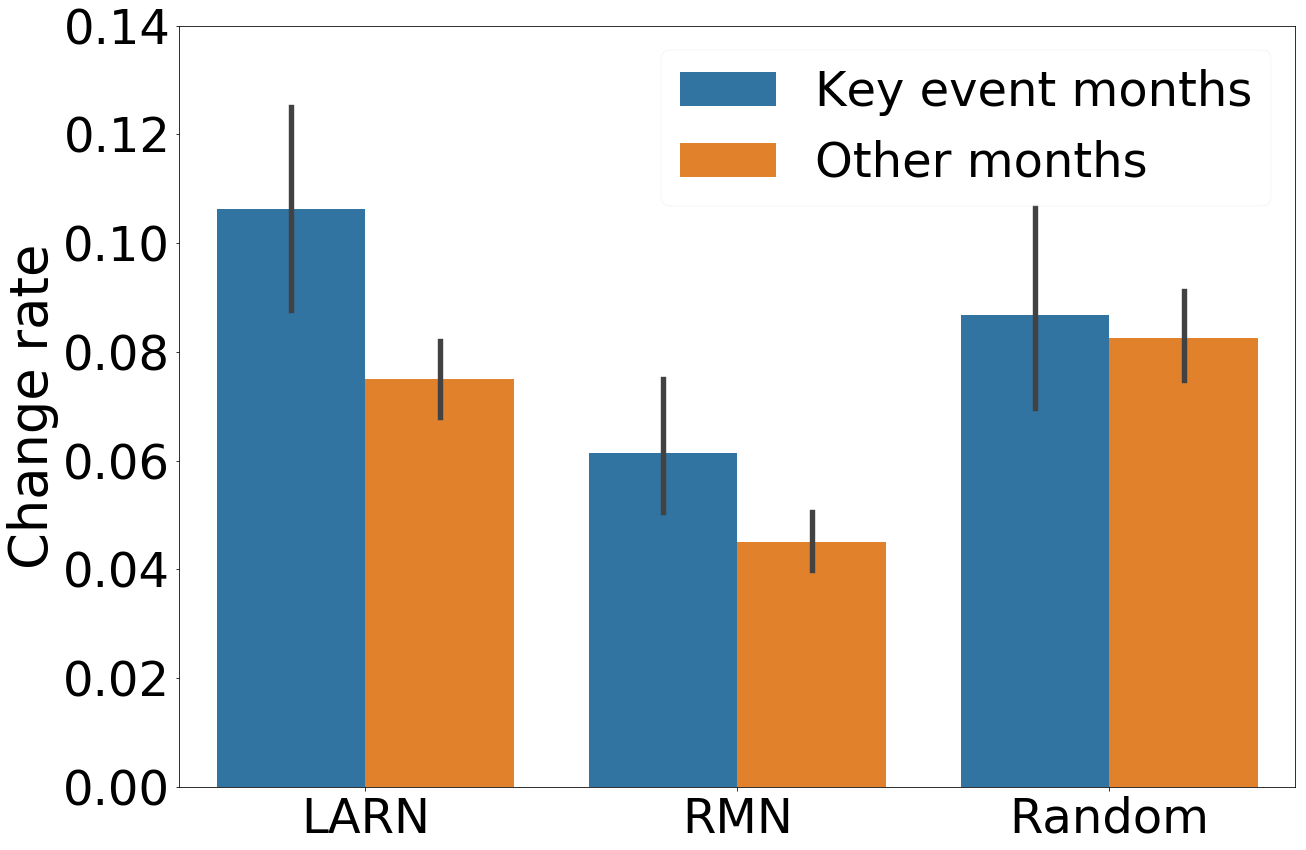

In [23]:
from matplotlib.ticker import FormatStrFormatter

sns.set_context("paper", font_scale=6, rc={"lines.linewidth": 3})
plt.figure(figsize=(20,14))
ax = sns.barplot(x='model', y='change_rate', hue='month', data=cp_info_dict)

ax.yaxis.set_label_text('Change rate')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_ticks(np.arange(0, 0.14, 0.02))
#ax.set(ylim=(0, None))
ax.figure.savefig('figures/cpa_2.pdf', dpi=200, bbox_inches='tight')